# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Pandas and numpy
import pandas as pd
import numpy as np

import datetime as dt
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from src.visualization.visualize import plot_confusion_matrix
from atomm.Tools import calc_open_position


# Feature building tool
from src.features.build_features import calcIndicators

from IPython.display import display, clear_output

In [3]:
# Load environment variables
load_dotenv(find_dotenv())

True

# Loading the data

In [35]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')

In [36]:
djia.shape

(2014, 250)

In [25]:
symbol_list = djia.columns.get_level_values(0).unique()

In [26]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]

In [27]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

# Target variable

## Forecast Horizon

The target of this project is to forecast future price movements of a given asset based on the different technical indicators. Technical indicators are mathematical formulas intended which reflect the past price movements. It is assumed that history will (at least partially) be repeated in the future.

In order to build a supervised machine learning model, we need a target variable. Here, we will use two different classifications for predicting the future price trend: A two label classification scheme (1: up, 0: down), and a three label classification scheme (1: up; 0: no movement; -1: down). In both cases, the relative future price change is used to label the training and test data set:
$$y(t)=\frac{C_{t+n}-C_t}{C_t}$$


## Calculate sample weights

In [28]:
def calculate_sample_weights(df, symbol_list):
    df_weights = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    weight_dic = {}
    for symbol in symbol_list:
        data = df[symbol]
        dictw = {}
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            dictw[f'weight_{n}'] = diff*100

        weight_df = pd.DataFrame.from_dict(dictw)

        weight_dic[symbol] = weight_df

    df_weights = pd.concat(weight_dic.values(), keys=weight_dic.keys(), axis=1)

    return df_weights

In [29]:
ws = calculate_sample_weights(djia, symbol_list)

In [30]:
ws.head()

CNC                                          \
                           weight_1  weight_3  weight_5  weight_7 weight_10   
Epoch                                                                         
2011-12-19 00:00:00+00:00  4.604580  3.381902  5.463066  4.474509  2.367325   
2011-12-20 00:00:00+00:00 -0.870426 -0.497391 -2.064158 -1.541902  2.213378   
2011-12-21 00:00:00+00:00 -0.301051  1.705972  0.752632  0.376311  6.271952   
2011-12-22 00:00:00+00:00  0.679408 -0.905890 -0.377457 -0.981387  9.713127   
2011-12-23 00:00:00+00:00  1.324675  0.374910  0.000000  2.724319  8.972757   

                                                                       \
                           weight_15  weight_20  weight_25  weight_30   
Epoch                                                                   
2011-12-19 00:00:00+00:00  14.177942  15.400630  11.888658  21.331947   
2011-12-20 00:00:00+00:00   9.574739   9.102213  10.121860  15.095747   
2011-12-21 00:00:00+00:00  10.060206   8.805816   9.759155  14.400395   
2011-12-22 00:00:00+00:00  11.952692  10.795161  13.739303  15.173624   
2011-12-23 00:00:00+00:00  11.397155   9.122724  15.821050  19.120224   

                                FMC  ...       IBM      MSFT            \
                           weight_1  ... weight_30  weight_1  weight_3   
Epoch                                ...                                 
2011-12-19 00:00:00+00:00  4.012499  ...  4.724151  1.958480  1.096744   
2011-12-20 00:00:00+00:00 -0.739200  ...  3.418070 -1.037266  0.000000   
2011-12-21 00:00:00+00:00  0.767973  ...  6.254481  0.194096  1.086959   
2011-12-22 00:00:00+00:00  0.889150  ...  6.212927  0.852388  0.038746   
2011-12-23 00:00:00+00:00  0.446377  ...  4.438428  0.038418 -0.038418   

                                                                              \
                           weight_5  weight_7 weight_10 weight_15  weight_20   
Epoch                                                                          
2011-12-19 00:00:00+00:00  1.997651  1.919310  7.324712  8.578138  10.144928   
2011-12-20 00:00:00+00:00 -0.806765 -0.268927  6.338839  7.568188  14.137527   
2011-12-21 00:00:00+00:00  1.009318  3.920808  9.122672  9.666148  15.411488   
2011-12-22 00:00:00+00:00  0.581169  6.160404  7.477723  9.492448  13.676873   
2011-12-23 00:00:00+00:00  2.842873  6.338839  6.953513  8.451781  13.561271   

                                                 
                           weight_25  weight_30  
Epoch                                            
2011-12-19 00:00:00+00:00  15.550330  17.312965  
2011-12-20 00:00:00+00:00  12.293503  16.173641  
2011-12-21 00:00:00+00:00  14.945653  17.236027  
2011-12-22 00:00:00+00:00  14.413023  17.590084  
2011-12-23 00:00:00+00:00  14.829038  17.787165  

[5 rows x 450 columns]

In [31]:
ws.shape

(2014, 450)

In [32]:
ws = ws[max(input_window_size):-max(forecast_horizon)]

In [33]:
ws.shape

(1954, 450)

## Two-class classification

For the two label classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt 0$ }\\0, & \text{if $ y(t)\lt 0$ } \\\end{cases}$$

In [12]:
def create_two_class_signal(df, symbol_list):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    sign_dic = {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti, dictw = {}, {}
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal = np.where(diff > 0, 1, 0)
            dicti[f'signal_{n}'] = signal
            dictw[f'weight_{n}'] = diff*100
        sign_df = pd.DataFrame.from_dict(dicti)
        sign_df.index = diff.index
        sign_dic[symbol] = sign_df
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    return df_signals

In [17]:
#dicti = {}
y_2c = create_two_class_signal(djia, symbol_list)

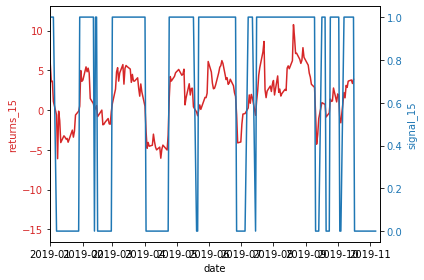

In [91]:
fig, ax1 = plt.subplots(sharex=True)

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('returns_15', color=color)
ax1.plot(w['T']['weight_15'].index, w_2c['T']['weight_15'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('signal_15', color=color)  # we already handled the x-label with ax1
ax2.plot(y_2c['T']['signal_15'].index, y_2c['T']['signal_15'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2019, 11, 10))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Some NaNs, most of them are probably due to the fact
Drop the first x days of X, where is the maximum lookback window size

In [15]:
# Remove first and last 30 entries
y_2c = y_2c[max(input_window_size):-max(forecast_horizon)]

In [18]:
y_2c.shape

(1954, 450)

### Is data balanced?

Calculate percentage of data points assigned to each class

In [19]:
l1 = []
for y in y_2c.columns.get_level_values(0).unique():
    l = []
    for x in y_2c[y].columns:
        c = y_2c[y][x].value_counts()
        s = c[0] + c[1]
        l.append([c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['0', '1']), columns=y_2c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
0,0.475722,0.459754,0.452446,0.448495,0.441945,0.434381,0.429806,0.4248,0.420082
1,0.524278,0.540246,0.547554,0.551505,0.558055,0.565619,0.570194,0.5752,0.579918


### Checking distribution of weights

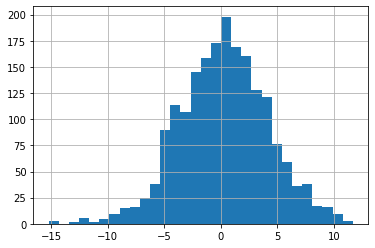

In [93]:
w['T']['weight_15'].hist(bins=30)

### Plot signals and open positions

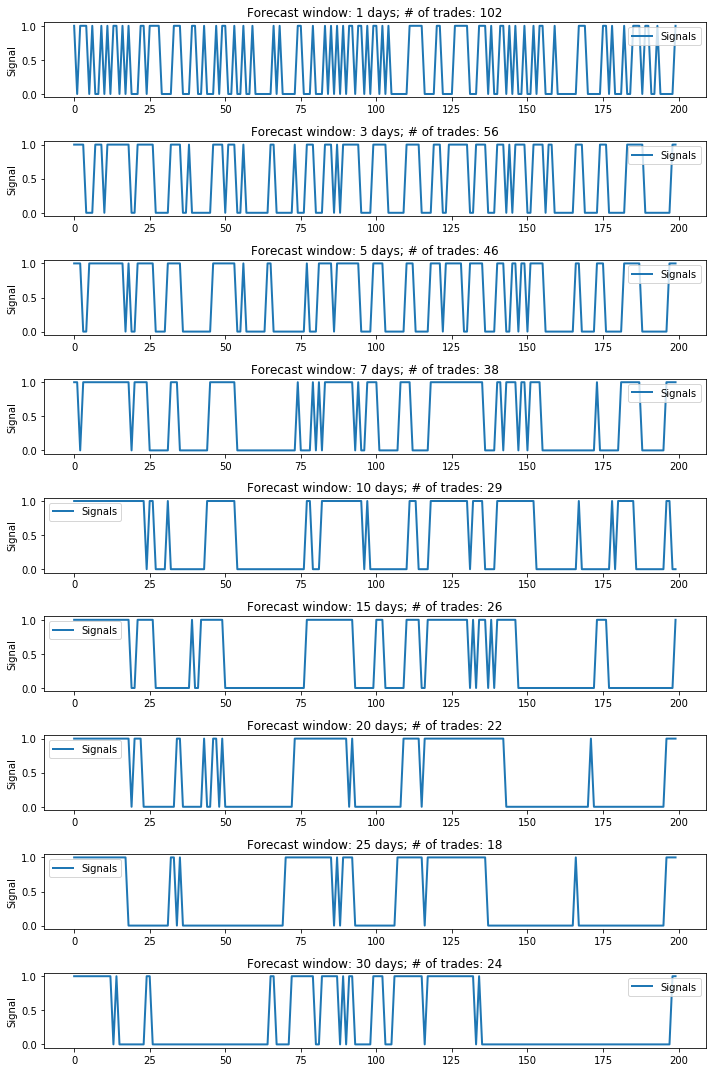

In [22]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
symbol = 'MSFT'
for i, n in enumerate(forecast_horizon):
    plt.subplot(len(forecast_horizon), 1, i+1)
    plt.plot(y_2c[symbol][f'signal_{n}'][:window], lw=2, label='Signals')
    #plt.plot(y_3c[f'AAPL_open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_2c[symbol][f'signal_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

## Three class classification

For the three class classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt \delta$ }\\0, & \text{if $-\delta \leq y(t)\leq \delta$ } \\-1, & \text{if $ y(t)\lt -\delta$ }\end{cases}$$

where the threshold $\delta$ is a parameter of the strategy that needs tuning. The thresholds taken here for the 1, 3, 5, 7, ... , 30 day forecast are the same Shynkevich et al 2017 used.

In [104]:
threshold_list = [0.63, 1.15, 1.49, 1.79, 2.14, 2.65, 3.08, 3.48, 3.94]

In [105]:
def create_three_class_signal(df, symbol_list, threshold=None, multi=1):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    df_op = df_signals.copy()
    sign_dic, op_dic = {}, {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti, dict_op = {}, {}
        for n, thresh in zip(forecast_horizon, threshold):
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal1p = np.where(diff > multi*thresh/100, 1, 0)
            signal1n = np.where(diff < -multi*thresh/100, -1, 0)
            signal = signal1p + signal1n
            open_position = calc_open_position(signal)
            dicti[f'signal_{n}'] = signal
            dict_op[f'open_position_{n}'] = open_position
        sign_dic[symbol] = pd.DataFrame.from_dict(dicti)
        op_dic[symbol] = pd.DataFrame.from_dict(dict_op)
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    df_op = pd.concat(op_dic.values(), keys=op_dic.keys(), axis=1)
    return df_signals, df_op

In [106]:
#%%timeit

sym_list = symbol_list[:]

#dicti = {}
y_3c, y_3op = create_three_class_signal(djia, sym_list, threshold=threshold_list)
y_3c_test, y_3op_test = create_three_class_signal(djia, sym_list, threshold=threshold_list)

# Remove first and last 30 entries
#y_3c = y_3c[max(input_window_size):-max(forecast_horizon)]
#y_3op = y_3op[max(input_window_size):-max(forecast_horizon)]

In [107]:
y_3c.shape, y_3op.shape

((1954, 450), (1954, 450))

### Calculate percentage of data points assigned to each class

In [108]:
l1 = []
for y in y_3c.columns.get_level_values(0).unique():
    l = []
    for x in y_3c[y].columns:
        c = y_3c[y][x].value_counts()
        s = c[0] + c[1] + c[-1]
        l.append([c[-1]/s, c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['-1', '0', '1']), columns=y_3c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
-1,0.267503,0.256233,0.253808,0.249611,0.244289,0.238895,0.235343,0.230368,0.220338
0,0.424023,0.427830,0.418813,0.420215,0.417605,0.414033,0.408188,0.406991,0.419007
1,0.308475,0.315937,0.327380,0.330174,0.338106,0.347073,0.356469,0.362641,0.360655


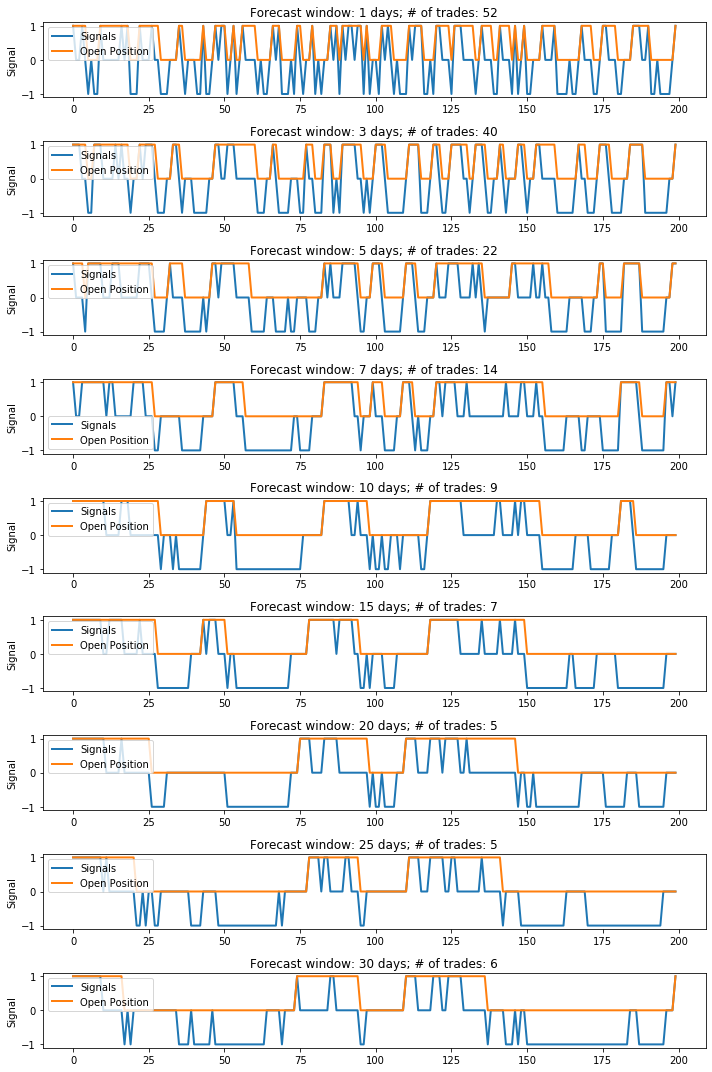

In [109]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
symbol = 'MSFT'
for i, n in enumerate(forecast_horizon):
    plt.subplot(len(forecast_horizon), 1, i+1)
    plt.plot(y_3c[symbol][f'signal_{n}'][:window], lw=2, label='Signals')
    plt.plot(y_3op[symbol][f'open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_3op[symbol][f'open_position_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

# Feature Engineering - Technical Indicators

Technical chart indicators are heuristic or mathematical calculations used by traders to predict future price movements of a security (stock). The calculations are purely based on prices (open, high, low, close) data, as well as information of the volume traded. 
Examples: Relative Strength Index, Money Flow Index, Stochastics, MACD and Bollinger Bands.

For this project, the following technical indicators will be used as features to train different machine learning models.

1. MACD - Moving average convergence-divergence: Is based on the difference of two exponential moving averages. In a standard setting, the 12-day / 26-day MAs are used:
$$\text{MACD}(n_{\text{slow}}, n_{\text{fast}})=EMA(n_{\text{slow}})-EMA(n_{\text{fast}})$$
2. RSI - Relative strength indictor:
3. ROC - rate of change:
4. BB - Bollinger Bands:
5. SMA - Simple moving average: Is arithmetic mean of prices $p_i$ for defined time period of N observations. 
$$\text{SMA}=\frac{\Sigma_{i}^{N}{C_i}}{N}$$
6. EMA - Exponential moving average: a moving average that places a greater weight on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. The EMA reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

7. ATR - Average True Range: The ATR is a measure of price volatility. It is typically derived from the 14-day MA of a series of true range indicators. The true range (TR) is computed as the maximum of the following: a) current high ($H_t$) less the current low, b) the absolute value of the current high less the previous close c) the absolute value of the current low less the previous close. TR and ATR are computed as follows:

$$\text{TR}=max((H_t-L_t), abs(H_{t-1}), max(L_{t-1}))$$
$$\text{ATR}=\text{SMA}_{n=14}(\text{TR})$$





8. ADX x
9. CCI x
10. WILLIAMSR x
11. STOCK_n x
12. STOCD EMA_n(STOCK) x

In [110]:
ti_list = ['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd', 'log_ret', \
           'autocorr_1', 'autocorr_3', 'autocorr_5', 'vol']+['macd','rsi', 'stoc', 'roc', 'bbu', 'bbl',\
            'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']+['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr',\
                                                               'adx', 'cci', 'williamsr', 'stocd']
ti_list = list(set(ti_list))
ti_list = ['stoc', 'atr', 'williamsr', 'cci', 'rsi', 'log_ret', 'adx', 'macd',\
           'roc', 'vol', 'ema', 'bb', 'stocd', 'sma', 'autocorr_1',\
           'autocorr_3','autocorr_5']

In [ ]:
mom_dict = {}

cnt = 1
start = time.time()
total = len(symbol_list)
for symbol in symbol_list:
    res = calcIndicators(djia, symbol, input_window_size, ti_list)
    mom_dict[symbol] = res
    clear_output(wait=True)
    display(f'Leg [{cnt} / {total}]; Last symbol: {symbol}; Elapsed time: {round(time.time()-start, 0)}s')
    cnt += 1
    
df_moments = pd.concat(mom_dict.values(), keys=mom_dict.keys(), axis=1)

'Leg [4 / 50]; Last symbol: RTN; Elapsed time: 245.0s'

Remove first and last 30 entries for the momentum indicator dataframe

In [1600]:
df_moments = df_moments.iloc[max(input_window_size):-max(forecast_horizon)]

In [1601]:
df_moments.shape

(1954, 4800)

In [1607]:
np.where(df_moments.isna())

(array([  17,  368,  497, 1302, 1758, 1924]),
 array([ 578,  866, 3266, 2306, 1442, 2882]))

In [1612]:
df_moments.iloc[1758, :][df_moments.iloc[1758, :].isna()]

M  stoc_3   NaN
Name: 2019-01-30 00:00:00+00:00, dtype: float64

In [1605]:
sum(df_moments.isna().sum())

6

Computing the technical indicators resulted in NaNs in 6 cases, all of which occurred for STOC indicator and time window 3. We will interpolate missing values for now.

In [1613]:
df_moments = df_moments.interpolate(limit=1)

In [1614]:
sum(df_moments.isna().sum())

0

Remove first and last 30 entries for the djia dataframe

In [1629]:
djia = djia.iloc[max(input_window_size):-max(forecast_horizon)]

In [1630]:
djia.shape

(1954, 250)

## Adding ARIMA predictions as feature

In [45]:
from src.features.build_features import ARIMAeval, ARIMAtune

In [48]:
import time
import warnings

In [159]:
warnings.filterwarnings(action='ignore')

syms = ['QCOM', 'MSFT']

mom_dict = {}

cnt = 1
start = time.time()
total = len(syms)
for symbol in syms:
    #res = calcIndicators(djia, symbol, input_window_size, ti_list)
    res = calcIndicators(djia[-50:], symbol, input_window_size, ['arima'])
    mom_dict[symbol] = res
    clear_output(wait=True)
    display(f'Leg [{cnt} / {total}]; Last symbol: {symbol}; Elapsed time: {round(time.time()-start, 0)}s')
    cnt += 1
    
df_arima = pd.concat(mom_dict.values(), keys=mom_dict.keys(), axis=1)


'Leg [2 / 2]; Last symbol: MSFT; Elapsed time: 122.0s'

In [177]:
input_window_size

[3, 5, 7, 10, 15, 20, 25, 30]

In [178]:
res.head()

,arima_3,arima_5,arima_7,arima_10,arima_15,arima_20,arima_25,arima_30
Epoch,,,,,,,,
2019-09-26 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
res = calcIndicators(djia[-30:], 'QCOM', input_window_size, ['arima'])

In [166]:
ARIMAeval(djia['QCOM']['Close'][-50:], lookahead=[1], d_lookback=1, order=(2, 1, 0))

([0], 1000000000000000.0)

In [171]:
from statsmodels.tsa.arima_model import ARIMA

In [175]:
model = ARIMA(djia['QCOM']['Close'][-50:].values, order=(2,1,0))
model_fit = model.fit(disp=0,) 
model_fit.forecast(steps=1)


(array([84.93521849]),
 array([1.38417509]),
 array([[82.22228517, 87.6481518 ]]))

<Figure size 1008x576 with 0 Axes>

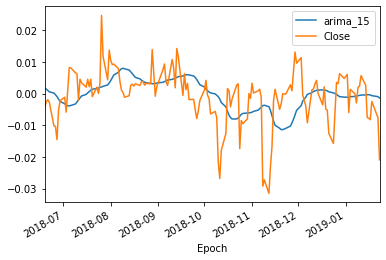

In [153]:
plt.figure(figsize=(14, 8))
true = np.log(djia['QCOM']['Close']).diff().ewm(span=5, adjust=False).mean()
res[['arima_15']] = res[['arima_15']].ewm(span=5, adjust=False).mean()
res[['arima_15']][-350:-200].plot()
true[-350:-200].plot()
plt.legend()


In [154]:
res['arima_15_sign'][15:].head(10)

Epoch
2012-02-24 00:00:00+00:00   -1.0
2012-02-27 00:00:00+00:00   -1.0
2012-02-28 00:00:00+00:00   -1.0
2012-02-29 00:00:00+00:00   -1.0
2012-03-01 00:00:00+00:00   -1.0
2012-03-02 00:00:00+00:00   -1.0
2012-03-05 00:00:00+00:00   -1.0
2012-03-06 00:00:00+00:00   -1.0
2012-03-07 00:00:00+00:00   -1.0
2012-03-08 00:00:00+00:00   -1.0
Name: arima_15_sign, dtype: float64

In [148]:
res['log_ret_sign'][15:].head(10)

Epoch
2012-02-24 00:00:00+00:00    1.0
2012-02-27 00:00:00+00:00    1.0
2012-02-28 00:00:00+00:00   -1.0
2012-02-29 00:00:00+00:00   -1.0
2012-03-01 00:00:00+00:00   -1.0
2012-03-02 00:00:00+00:00   -1.0
2012-03-05 00:00:00+00:00   -1.0
2012-03-06 00:00:00+00:00   -1.0
2012-03-07 00:00:00+00:00    1.0
2012-03-08 00:00:00+00:00    1.0
Name: log_ret_sign, dtype: float64

373

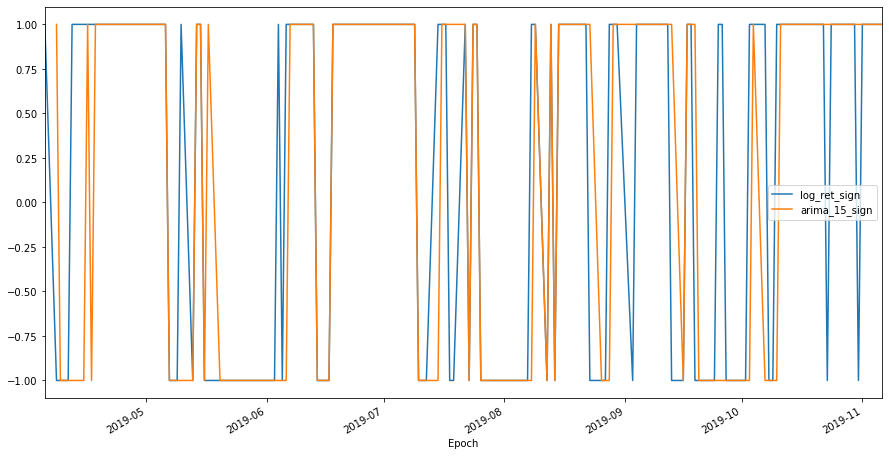

In [144]:
plt.figure(figsize=(15, 8))
res['log_ret_sign'] = np.sign(true)
res['log_ret_sign'][-150:].plot()
res['arima_15_sign'] = np.sign(res['arima_15'])
res['arima_15_sign'][-150:].shift().plot()
plt.legend()
sum(res['arima_15_sign'][15:] != res['log_ret_sign'][15:])

## Visualizing the technical indicators

In [1]:
symbol = 'MSFT'
X=df_moments
x_ = range(3, .shape[0])
x_ = list(X.index)

last_days = 200
n = 30
#plt.fill_between()
plt.figure(figsize=(14, 7), dpi=100)
#plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
plt.plot(djia[symbol]['Close'][:-last_days], label='Closing Price', color='k')
#plt.plot(X[symbol+'_macd1'],label='MACD 12, 26', color='r',linestyle='--')
plt.plot(X[f'{symbol}_bbu_{n}'][:-last_days], label='Upper Band', color='c')
plt.plot(X[f'{symbol}_bbl_{n}'][:-last_days], label='Lower Band', color='c')
plt.fill_between(X.index[:-last_days], X[f'{symbol}_bbu_{n}'][:-last_days], X[f'{symbol}_bbl_{n}'][:-last_days], color='c', alpha=0.35)
plt.title(f'Technical indicators for {symbol} - last {last_days} days.')
plt.ylabel('USD')
plt.legend()

NameError: name 'X' is not defined

In [476]:
#sns.pairplot(X.fillna(0))

In [477]:
X.fillna(0, inplace=True)

# Store data 

In [ ]:
# Price data of the 50 randomly selected stocks

In [37]:
djia = djia.iloc[max(input_window_size):-max(forecast_horizon)]

with pd.HDFStore(fname) as storage:
    storage.put('nyse/cleaned/rand_symbols', djia)
    print(storage.info())


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/robin/Documents/projects/python/capstone_nf/data/processed/index.h5
/nyse/cleaned/rand_symbols                     frame
/nyse/engineered/features                      frame
/nyse/engineered/target_three_class            frame
/nyse/engineered/target_two_class              frame
/nyse/engineered/weights                       frame
/nyse/prices                                   frame
/nyse/rand_symbols                             frame
/nyse/raw/rand_symbols                         frame
/nyse/raw/rand_symbols_raw                     frame


In [ ]:
# Two-class target variable

In [103]:
with pd.HDFStore(fname) as storage:
    storage.put('nyse/engineered/target_two_class', y_2c)
    print(storage.info())


NameError: name 'y_3c' is not defined

In [ ]:
# Three-class target variable

In [103]:
with pd.HDFStore(fname) as storage:
    storage.put('nyse/engineered/target_three_class', y_3c)
    print(storage.info())


NameError: name 'y_3c' is not defined

In [ ]:
# Sample weights

In [34]:
with pd.HDFStore(fname) as storage:
    storage.put('nyse/engineered/weights', ws)
    print(storage.info())


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/robin/Documents/projects/python/capstone_nf/data/processed/index.h5
/nyse/cleaned/rand_symbols                     frame
/nyse/engineered/features                      frame
/nyse/engineered/target_three_class            frame
/nyse/engineered/target_two_class              frame
/nyse/engineered/weights                       frame
/nyse/prices                                   frame
/nyse/rand_symbols                             frame
/nyse/raw/rand_symbols                         frame
/nyse/raw/rand_symbols_raw                     frame
